In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnnlstmnetwork import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3,n=2)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

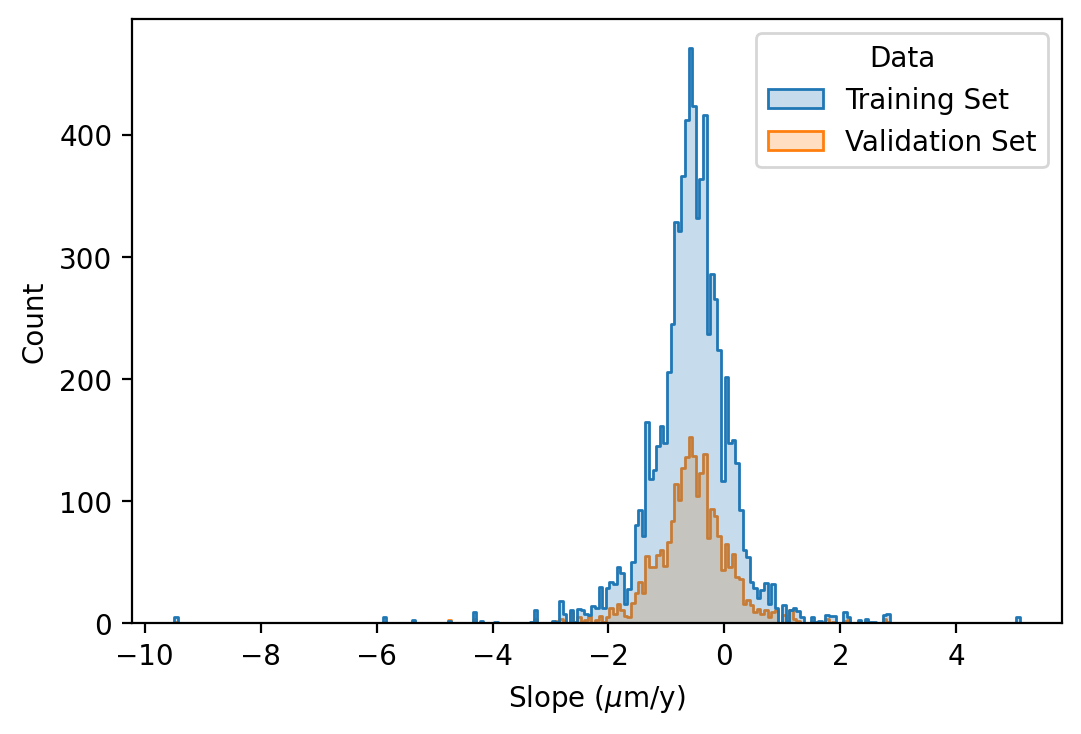

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

7759 2586


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [7]:
epochs = 150
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_dict_ts3.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/150]: 100%|██████████| 122/122 [00:23<00:00,  5.22it/s, batch_loss=0.202, running_loss=68]


Train Loss: 67.9813 | Valid Loss: inf ===========> 21.4501 | Test Loss: 18.9312 | Saving model...


Epoch [2/150]: 100%|██████████| 122/122 [00:23<00:00,  5.27it/s, batch_loss=0.202, running_loss=67.1]


Train Loss: 67.0610 | Valid Loss: 21.5025


Epoch [3/150]: 100%|██████████| 122/122 [00:23<00:00,  5.25it/s, batch_loss=0.34, running_loss=67]


Train Loss: 66.9943 | Valid Loss: 21.6289


Epoch [4/150]: 100%|██████████| 122/122 [00:23<00:00,  5.24it/s, batch_loss=0.222, running_loss=66.9]


Train Loss: 66.8650 | Valid Loss: 21.4501 ===========> 21.4260 | Test Loss: 18.8007 | Saving model...


Epoch [5/150]: 100%|██████████| 122/122 [00:23<00:00,  5.28it/s, batch_loss=0.291, running_loss=66.7]


Train Loss: 66.7359 | Valid Loss: 21.6608


Epoch [6/150]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.386, running_loss=66.3]


Train Loss: 66.3316 | Valid Loss: 21.7087


Epoch [7/150]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.412, running_loss=65.7]


Train Loss: 65.6715 | Valid Loss: 21.4260 ===========> 21.3636 | Test Loss: 18.8813 | Saving model...


Epoch [8/150]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=1.02, running_loss=65.2]


Train Loss: 65.1700 | Valid Loss: 24.3840


Epoch [9/150]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.499, running_loss=64.1]


Train Loss: 64.0589 | Valid Loss: 21.4370


Epoch [10/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.307, running_loss=62.5]


Train Loss: 62.5247 | Valid Loss: 23.7375


Epoch [11/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.335, running_loss=61.9]


Train Loss: 61.8920 | Valid Loss: 21.3636 ===========> 20.9240 | Test Loss: 18.2671 | Saving model...


Epoch [12/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.161, running_loss=59.5]


Train Loss: 59.4701 | Valid Loss: 21.5398


Epoch [13/150]: 100%|██████████| 122/122 [00:22<00:00,  5.42it/s, batch_loss=0.442, running_loss=60.5]


Train Loss: 60.5156 | Valid Loss: 20.9240 ===========> 20.1820 | Test Loss: 17.5344 | Saving model...


Epoch [14/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=1.18, running_loss=60.1]


Train Loss: 60.1083 | Valid Loss: 22.0053


Epoch [15/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=1.04, running_loss=54.9]


Train Loss: 54.8552 | Valid Loss: 20.4804


Epoch [16/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=5.44, running_loss=68.6]


Train Loss: 68.5520 | Valid Loss: 23.2652


Epoch [17/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0908, running_loss=67]


Train Loss: 67.0267 | Valid Loss: 21.4839


Epoch [18/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.252, running_loss=66.9]


Train Loss: 66.9351 | Valid Loss: 21.6485


Epoch [19/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.3, running_loss=67]


Train Loss: 66.9791 | Valid Loss: 21.4557


Epoch [20/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.287, running_loss=66.8]


Train Loss: 66.8233 | Valid Loss: 21.2617


Epoch [21/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.204, running_loss=65.2]


Train Loss: 65.1617 | Valid Loss: 21.1114


Epoch [22/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=1.59, running_loss=63.4]


Train Loss: 63.4481 | Valid Loss: 34.3762


Epoch [23/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.81, running_loss=60.4]


Train Loss: 60.3854 | Valid Loss: 23.0482


Epoch [24/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.679, running_loss=57.2]


Train Loss: 57.1850 | Valid Loss: 27.0990


Epoch [25/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=3.1, running_loss=53.8]


Train Loss: 53.8103 | Valid Loss: 21.8748


Epoch [26/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.0962, running_loss=54.9]


Train Loss: 54.9419 | Valid Loss: 20.1820 ===========> 19.8569 | Test Loss: 17.5852 | Saving model...


Epoch [27/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.133, running_loss=44]


Train Loss: 44.0386 | Valid Loss: 20.7942


Epoch [28/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.422, running_loss=42.9]


Train Loss: 42.8537 | Valid Loss: 24.0506


Epoch [29/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.454, running_loss=42.3]


Train Loss: 42.2585 | Valid Loss: 60.6143


Epoch [30/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.667, running_loss=38.6]


Train Loss: 38.6392 | Valid Loss: 29.2941


Epoch [31/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0626, running_loss=36.1]


Train Loss: 36.1038 | Valid Loss: 19.8569 ===========> 17.4103 | Test Loss: 15.8039 | Saving model...


Epoch [32/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0751, running_loss=30.6]


Train Loss: 30.6256 | Valid Loss: 17.4103 ===========> 17.1125 | Test Loss: 15.9628 | Saving model...


Epoch [33/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.192, running_loss=27.5]


Train Loss: 27.4517 | Valid Loss: 17.1125 ===========> 17.0387 | Test Loss: 15.8512 | Saving model...


Epoch [34/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.192, running_loss=25.7]


Train Loss: 25.6703 | Valid Loss: 17.8085


Epoch [35/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.251, running_loss=20.6]


Train Loss: 20.6470 | Valid Loss: 17.2579


Epoch [36/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.259, running_loss=19.9]


Train Loss: 19.8709 | Valid Loss: 24.6441


Epoch [37/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.142, running_loss=16.4]


Train Loss: 16.4263 | Valid Loss: 17.0387 ===========> 16.2274 | Test Loss: 14.5976 | Saving model...


Epoch [38/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0991, running_loss=12.9]


Train Loss: 12.8671 | Valid Loss: 16.2274 ===========> 16.1641 | Test Loss: 14.7233 | Saving model...


Epoch [39/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0612, running_loss=12.1]


Train Loss: 12.1133 | Valid Loss: 16.1641 ===========> 15.5145 | Test Loss: 14.2366 | Saving model...


Epoch [40/150]: 100%|██████████| 122/122 [00:22<00:00,  5.42it/s, batch_loss=0.0772, running_loss=11]


Train Loss: 11.0168 | Valid Loss: 15.5145 ===========> 15.0157 | Test Loss: 13.6402 | Saving model...


Epoch [41/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0867, running_loss=9.38]


Train Loss: 9.3829 | Valid Loss: 15.0876


Epoch [42/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0585, running_loss=8.86]


Train Loss: 8.8568 | Valid Loss: 15.8506


Epoch [43/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.19, running_loss=7.88]


Train Loss: 7.8762 | Valid Loss: 16.6990


Epoch [44/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0535, running_loss=7.68]


Train Loss: 7.6771 | Valid Loss: 15.0157 ===========> 14.6793 | Test Loss: 13.7515 | Saving model...


Epoch [45/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0382, running_loss=5.96]


Train Loss: 5.9577 | Valid Loss: 14.6793 ===========> 13.9269 | Test Loss: 12.9127 | Saving model...


Epoch [46/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.0334, running_loss=5.16]


Train Loss: 5.1606 | Valid Loss: 14.0381


Epoch [47/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0199, running_loss=5.61]


Train Loss: 5.6089 | Valid Loss: 14.0203


Epoch [48/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.018, running_loss=5.02]


Train Loss: 5.0173 | Valid Loss: 13.9269 ===========> 13.5844 | Test Loss: 12.6903 | Saving model...


Epoch [49/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0467, running_loss=4.67]


Train Loss: 4.6702 | Valid Loss: 14.2233


Epoch [50/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0245, running_loss=4.1]


Train Loss: 4.1037 | Valid Loss: 14.7400


Epoch [51/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0329, running_loss=4]


Train Loss: 3.9982 | Valid Loss: 14.1112


Epoch [52/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0224, running_loss=3.37]


Train Loss: 3.3738 | Valid Loss: 14.1563


Epoch [53/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.02, running_loss=3.46]


Train Loss: 3.4559 | Valid Loss: 13.6832


Epoch [54/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0398, running_loss=3.31]


Train Loss: 3.3070 | Valid Loss: 14.9672


Epoch [55/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0226, running_loss=3.21]


Train Loss: 3.2146 | Valid Loss: 13.5844 ===========> 13.3047 | Test Loss: 12.3215 | Saving model...


Epoch [56/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00883, running_loss=3]


Train Loss: 3.0049 | Valid Loss: 13.3047 ===========> 12.9562 | Test Loss: 12.0089 | Saving model...


Epoch [57/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0199, running_loss=3]


Train Loss: 2.9974 | Valid Loss: 13.5162


Epoch [58/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0445, running_loss=2.75]


Train Loss: 2.7510 | Valid Loss: 13.0574


Epoch [59/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0388, running_loss=2.76]


Train Loss: 2.7604 | Valid Loss: 13.5002


Epoch [60/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0302, running_loss=2.56]


Train Loss: 2.5604 | Valid Loss: 12.9562 ===========> 12.6935 | Test Loss: 11.7743 | Saving model...


Epoch [61/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0148, running_loss=2.53]


Train Loss: 2.5266 | Valid Loss: 12.8360


Epoch [62/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0134, running_loss=2.32]


Train Loss: 2.3172 | Valid Loss: 12.7934


Epoch [63/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00975, running_loss=2.28]


Train Loss: 2.2822 | Valid Loss: 12.7443


Epoch [64/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0324, running_loss=2.31]


Train Loss: 2.3137 | Valid Loss: 12.6935 ===========> 12.4889 | Test Loss: 12.1470 | Saving model...


Epoch [65/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0129, running_loss=2.31]


Train Loss: 2.3144 | Valid Loss: 12.6775


Epoch [66/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0264, running_loss=2.09]


Train Loss: 2.0884 | Valid Loss: 13.2470


Epoch [67/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0157, running_loss=2.22]


Train Loss: 2.2170 | Valid Loss: 12.8280


Epoch [68/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0111, running_loss=1.95]


Train Loss: 1.9513 | Valid Loss: 12.6748


Epoch [69/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0204, running_loss=2]


Train Loss: 1.9964 | Valid Loss: 12.7930


Epoch [70/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0202, running_loss=2.06]


Train Loss: 2.0649 | Valid Loss: 12.6924


Epoch [71/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.017, running_loss=2.07]


Train Loss: 2.0660 | Valid Loss: 12.9707


Epoch [72/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0194, running_loss=2]


Train Loss: 2.0036 | Valid Loss: 12.9927


Epoch [73/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.029, running_loss=1.8]


Train Loss: 1.8044 | Valid Loss: 13.3970


Epoch [74/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00995, running_loss=1.83]


Train Loss: 1.8306 | Valid Loss: 12.6573


Epoch [75/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0464, running_loss=1.82]


Train Loss: 1.8174 | Valid Loss: 12.4889 ===========> 12.2913 | Test Loss: 11.3084 | Saving model...


Epoch [76/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00987, running_loss=1.87]


Train Loss: 1.8717 | Valid Loss: 12.5727


Epoch [77/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0131, running_loss=1.73]


Train Loss: 1.7255 | Valid Loss: 13.8257


Epoch [78/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0208, running_loss=1.79]


Train Loss: 1.7926 | Valid Loss: 13.0788


Epoch [79/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00656, running_loss=1.65]


Train Loss: 1.6531 | Valid Loss: 12.7965


Epoch [80/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.018, running_loss=1.67]


Train Loss: 1.6710 | Valid Loss: 12.3956


Epoch [81/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0202, running_loss=1.66]


Train Loss: 1.6591 | Valid Loss: 12.9356


Epoch [82/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00588, running_loss=1.58]


Train Loss: 1.5817 | Valid Loss: 12.4055


Epoch [83/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00943, running_loss=1.53]


Train Loss: 1.5338 | Valid Loss: 12.2913 ===========> 12.1255 | Test Loss: 11.2702 | Saving model...


Epoch [84/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0298, running_loss=1.67]


Train Loss: 1.6749 | Valid Loss: 12.1255 ===========> 11.9020 | Test Loss: 11.3169 | Saving model...


Epoch [85/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0403, running_loss=1.63]


Train Loss: 1.6308 | Valid Loss: 12.1607


Epoch [86/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00693, running_loss=1.64]


Train Loss: 1.6415 | Valid Loss: 12.2523


Epoch [87/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0217, running_loss=1.5]


Train Loss: 1.5035 | Valid Loss: 11.9253


Epoch [88/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0583, running_loss=1.55]


Train Loss: 1.5549 | Valid Loss: 12.6799


Epoch [89/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0098, running_loss=1.68]


Train Loss: 1.6818 | Valid Loss: 12.0078


Epoch [90/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0277, running_loss=1.53]


Train Loss: 1.5314 | Valid Loss: 12.0380


Epoch [91/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0115, running_loss=1.5]


Train Loss: 1.4951 | Valid Loss: 12.1210


Epoch [92/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0125, running_loss=1.46]


Train Loss: 1.4556 | Valid Loss: 12.6175


Epoch [93/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00361, running_loss=1.44]


Train Loss: 1.4402 | Valid Loss: 11.9561


Epoch [94/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0171, running_loss=1.36]


Train Loss: 1.3593 | Valid Loss: 12.2697


Epoch [95/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.00975, running_loss=1.49]


Train Loss: 1.4876 | Valid Loss: 12.3674


Epoch [96/150]: 100%|██████████| 122/122 [00:22<00:00,  5.42it/s, batch_loss=0.00591, running_loss=1.28]


Train Loss: 1.2805 | Valid Loss: 12.1353


Epoch [97/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00567, running_loss=1.32]


Train Loss: 1.3209 | Valid Loss: 11.9986


Epoch [98/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00701, running_loss=1.31]


Train Loss: 1.3064 | Valid Loss: 12.0828


Epoch [99/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0186, running_loss=1.25]


Train Loss: 1.2482 | Valid Loss: 12.0728


Epoch [100/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0242, running_loss=1.36]


Train Loss: 1.3558 | Valid Loss: 12.1048


Epoch [101/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0127, running_loss=1.2]


Train Loss: 1.2028 | Valid Loss: 12.1848


Epoch [102/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0139, running_loss=1.17]


Train Loss: 1.1712 | Valid Loss: 12.0844


Epoch [103/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00884, running_loss=1.12]


Train Loss: 1.1244 | Valid Loss: 12.0707


Epoch [104/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00852, running_loss=1.14]


Train Loss: 1.1385 | Valid Loss: 12.1383


Epoch [105/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0148, running_loss=1.11]


Train Loss: 1.1071 | Valid Loss: 12.2182


Epoch [106/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0261, running_loss=1.13]


Train Loss: 1.1268 | Valid Loss: 12.0096


Epoch [107/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0226, running_loss=1.13]


Train Loss: 1.1253 | Valid Loss: 11.9630


Epoch [108/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0119, running_loss=1.07]


Train Loss: 1.0659 | Valid Loss: 12.0167


Epoch [109/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0123, running_loss=1.07]


Train Loss: 1.0672 | Valid Loss: 11.9918


Epoch [110/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00617, running_loss=1.08]


Train Loss: 1.0825 | Valid Loss: 11.9696


Epoch [111/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0108, running_loss=1.05]


Train Loss: 1.0482 | Valid Loss: 12.1354


Epoch [112/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0218, running_loss=1.09]


Train Loss: 1.0939 | Valid Loss: 12.1416


Epoch [113/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00903, running_loss=1.06]


Train Loss: 1.0626 | Valid Loss: 12.1387


Epoch [114/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00458, running_loss=1.03]


Train Loss: 1.0272 | Valid Loss: 12.0095


Epoch [115/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.01, running_loss=1.03]


Train Loss: 1.0260 | Valid Loss: 11.9740


Epoch [116/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0093, running_loss=1.04]


Train Loss: 1.0404 | Valid Loss: 11.9676


Epoch [117/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.00895, running_loss=1.03]


Train Loss: 1.0341 | Valid Loss: 12.0736


Epoch [118/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00543, running_loss=1]


Train Loss: 1.0006 | Valid Loss: 12.0479


Epoch [119/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00441, running_loss=1.04]


Train Loss: 1.0379 | Valid Loss: 11.9637


Epoch [120/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00793, running_loss=1.01]


Train Loss: 1.0050 | Valid Loss: 12.0995


Epoch [121/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.016, running_loss=1.04]


Train Loss: 1.0362 | Valid Loss: 11.9990


Epoch [122/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0135, running_loss=1.01]


Train Loss: 1.0097 | Valid Loss: 12.0242


Epoch [123/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0106, running_loss=0.964]


Train Loss: 0.9638 | Valid Loss: 11.9793


Epoch [124/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00686, running_loss=1.02]


Train Loss: 1.0244 | Valid Loss: 12.0460


Epoch [125/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0101, running_loss=0.991]


Train Loss: 0.9913 | Valid Loss: 11.9842


Epoch [126/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00707, running_loss=0.984]


Train Loss: 0.9835 | Valid Loss: 12.2432


Epoch [127/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0108, running_loss=1.01]


Train Loss: 1.0090 | Valid Loss: 11.9197


Epoch [128/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0151, running_loss=0.996]


Train Loss: 0.9959 | Valid Loss: 12.0408


Epoch [129/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00599, running_loss=0.983]


Train Loss: 0.9834 | Valid Loss: 12.1279


Epoch [130/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.00611, running_loss=0.975]


Train Loss: 0.9749 | Valid Loss: 12.0890


Epoch [131/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0085, running_loss=0.988]


Train Loss: 0.9877 | Valid Loss: 12.0608


Epoch [132/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0191, running_loss=0.979]


Train Loss: 0.9790 | Valid Loss: 12.0133


Epoch [133/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00439, running_loss=1.02]


Train Loss: 1.0170 | Valid Loss: 11.9569


Epoch [134/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00307, running_loss=0.947]


Train Loss: 0.9465 | Valid Loss: 12.0599


Epoch [135/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.0103, running_loss=0.957]


Train Loss: 0.9570 | Valid Loss: 11.9667


Epoch [136/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.00369, running_loss=0.987]


Train Loss: 0.9871 | Valid Loss: 12.0105


Epoch [137/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.00658, running_loss=0.962]


Train Loss: 0.9619 | Valid Loss: 11.9919


Epoch [138/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.00439, running_loss=0.985]


Train Loss: 0.9851 | Valid Loss: 12.0091


Epoch [139/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00685, running_loss=0.961]


Train Loss: 0.9611 | Valid Loss: 12.1295


Epoch [140/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00793, running_loss=0.943]


Train Loss: 0.9429 | Valid Loss: 12.2196


Epoch [141/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00702, running_loss=0.97]


Train Loss: 0.9698 | Valid Loss: 12.3784


Epoch [142/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00854, running_loss=0.937]


Train Loss: 0.9374 | Valid Loss: 12.0270


Epoch [143/150]: 100%|██████████| 122/122 [00:22<00:00,  5.46it/s, batch_loss=0.0101, running_loss=0.983]


Train Loss: 0.9835 | Valid Loss: 12.4388


Epoch [144/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.00919, running_loss=0.951]


Train Loss: 0.9513 | Valid Loss: 12.4166


Epoch [145/150]: 100%|██████████| 122/122 [00:22<00:00,  5.45it/s, batch_loss=0.00457, running_loss=0.956]


Train Loss: 0.9562 | Valid Loss: 12.0220


Epoch [146/150]: 100%|██████████| 122/122 [00:22<00:00,  5.42it/s, batch_loss=0.00618, running_loss=0.98]


Train Loss: 0.9800 | Valid Loss: 12.3851


Epoch [147/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0112, running_loss=0.939]


Train Loss: 0.9385 | Valid Loss: 11.9552


Epoch [148/150]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.0137, running_loss=0.955]


Train Loss: 0.9552 | Valid Loss: 12.0130


Epoch [149/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.0155, running_loss=0.946]


Train Loss: 0.9460 | Valid Loss: 12.4687


Epoch [150/150]: 100%|██████████| 122/122 [00:22<00:00,  5.44it/s, batch_loss=0.00752, running_loss=0.954]


Train Loss: 0.9535 | Valid Loss: 11.9252


Train Loss: 1.6749 | Valid Loss: 11.9020 | Test Loss on Best Model: 11.3169


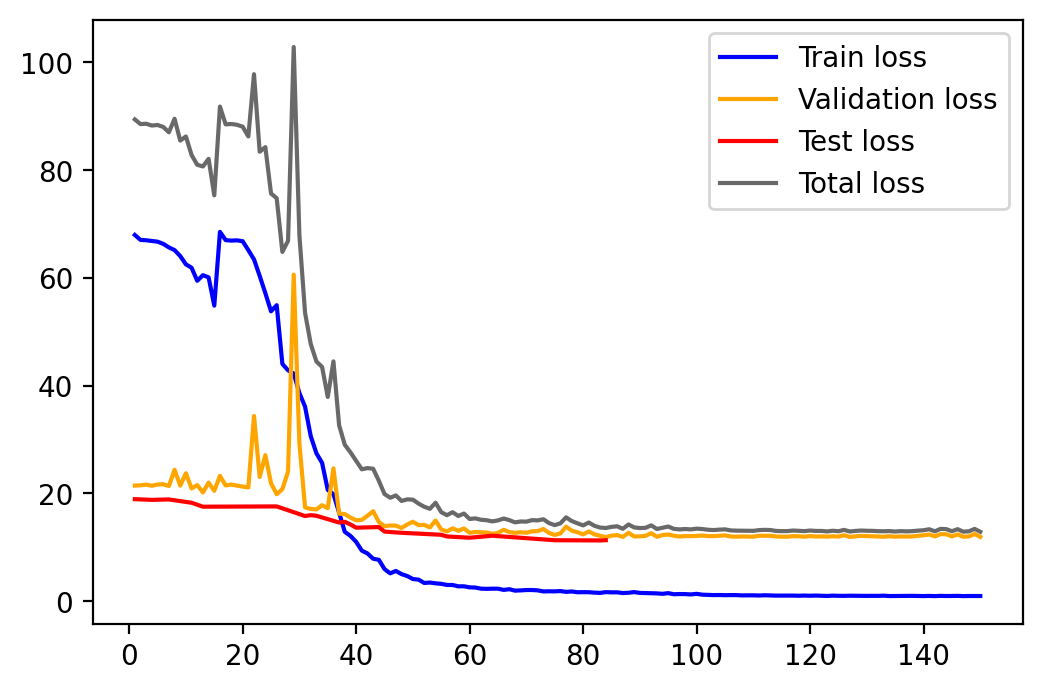

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('state_dict_ts3.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


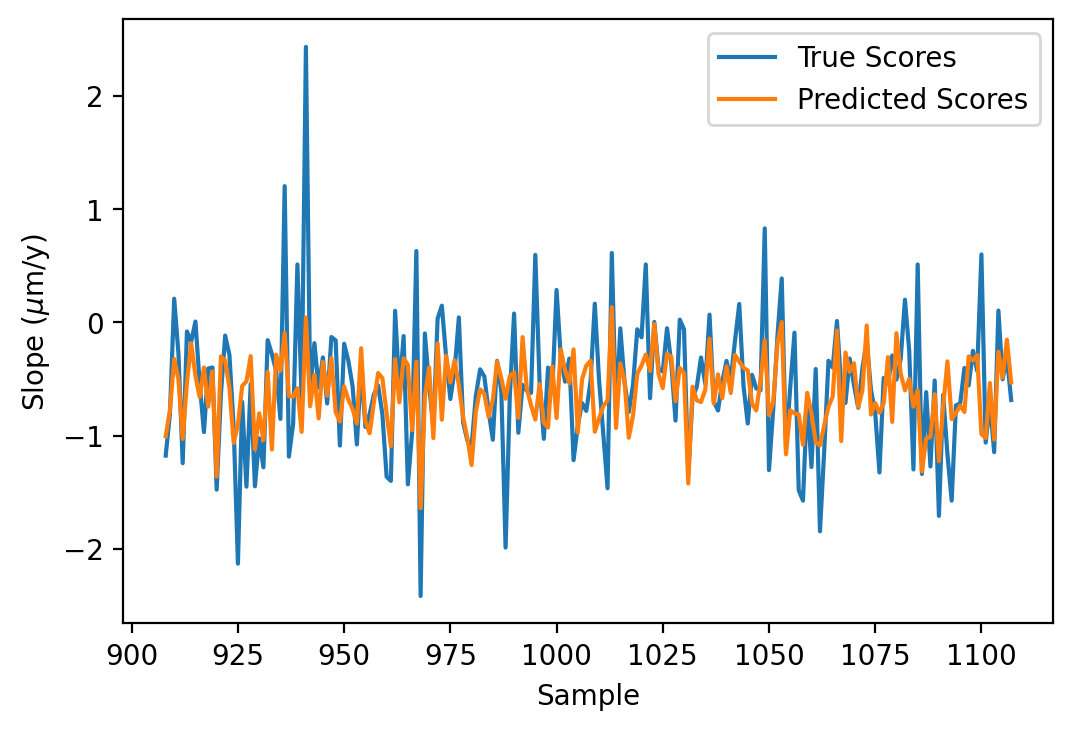

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

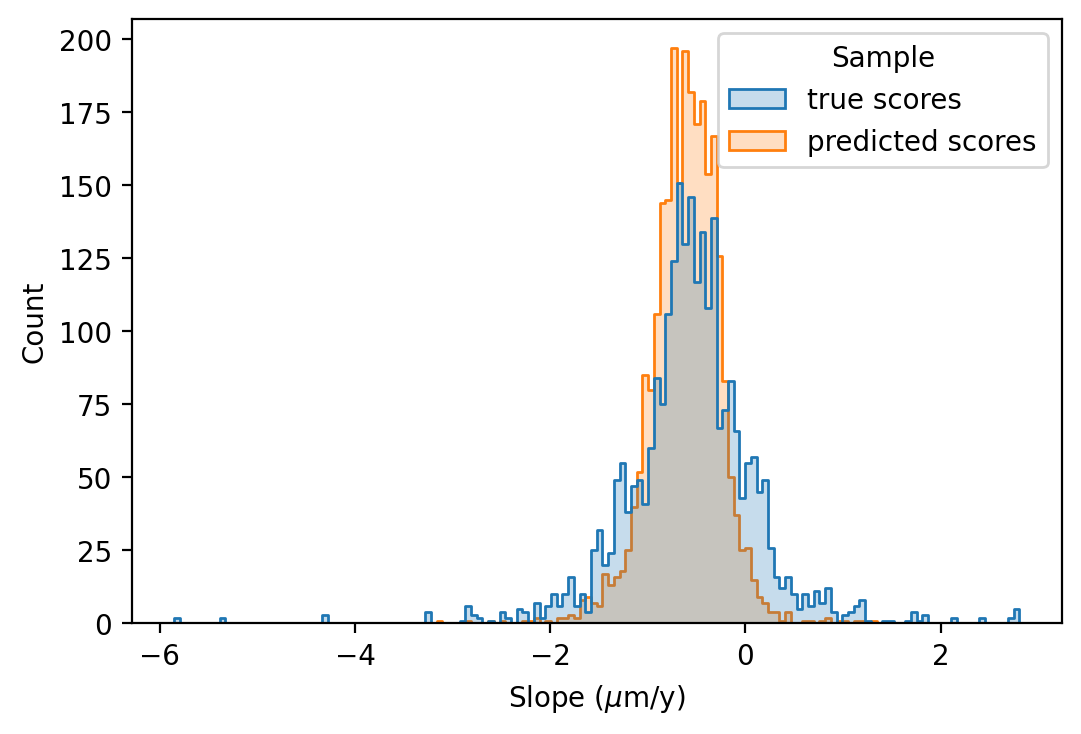

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.14998067259373793, pvalue=8.663164354118713e-26)


In [13]:
df.to_csv('predscores.csv')

In [14]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

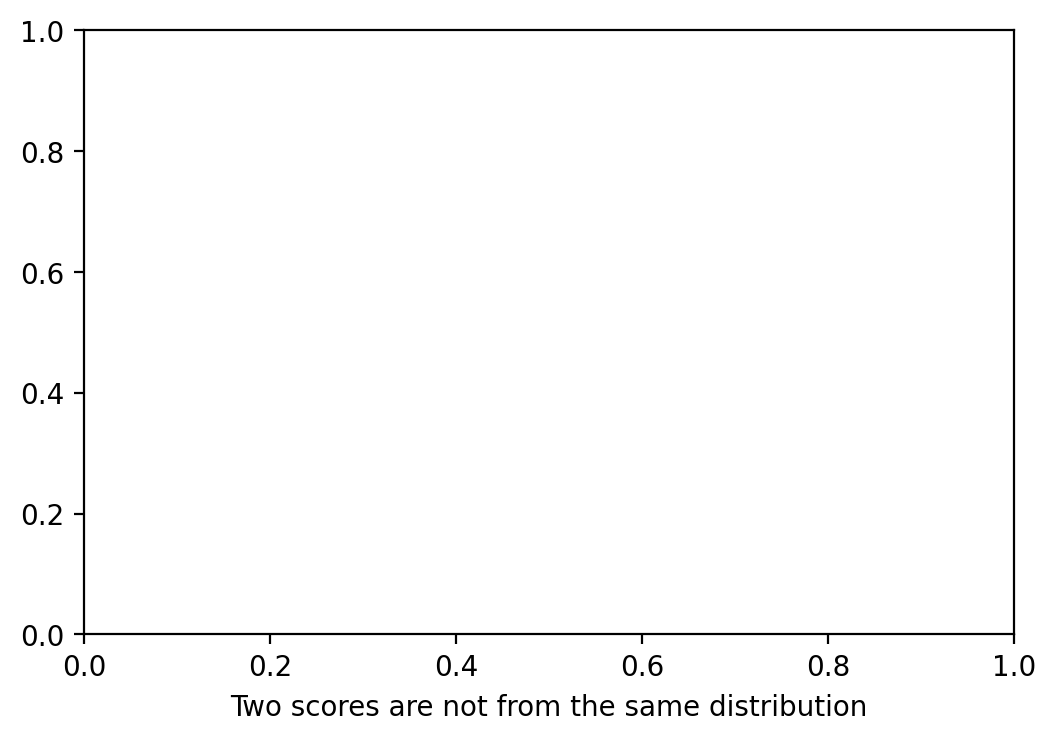

In [15]:
if ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05:
    plt.xlabel('Two scores are not from the same distribution')
else:
    plt.xlabel('Two scores are from the same distribution')

In [16]:
import pandas as pd
import numpy as np

In [17]:
df = pd.read_csv('predscores.csv')

In [18]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [19]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [20]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [21]:
coefficient_of_dermination

0.40251700781725674

In [22]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [23]:
rsquared(true, pred)

0.4209654738431332

In [24]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6030626120553887, pvalue=4.588904553979786e-256)

In [25]:
scipy.stats.pearsonr(true, pred)

(0.6488185215013, 4.773410488104884e-309)